[View in Colaboratory](https://colab.research.google.com/github/daphnei/weakvideo/blob/master/visualize_faces.ipynb)

In [2]:
#@title Clone the repo and get data.
! git clone https://github.com/daphnei/weakvideo.git
!wget www.seas.upenn.edu/~daphnei/images/ep7/face_data.pkl .


Cloning into 'weakvideo'...
remote: Counting objects: 310, done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 310 (delta 23), reused 17 (delta 8), pack-reused 254
Receiving objects: 100% (310/310), 215.61 MiB | 25.11 MiB/s, done.
Resolving deltas: 100% (105/105), done.
--2018-05-20 04:20:34--  http://www.seas.upenn.edu/~daphnei/images/ep7/face_data.pkl
Resolving www.seas.upenn.edu (www.seas.upenn.edu)... 158.130.68.91, 2607:f470:8:64:5ea5::9
Connecting to www.seas.upenn.edu (www.seas.upenn.edu)|158.130.68.91|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57979747 (55M)
Saving to: ‘face_data.pkl’

face_data.pkl       100%[===================>]  55.29M  87.2MB/s    in 0.6s    

2018-05-20 04:20:35 (87.2 MB/s) - ‘face_data.pkl’ saved [57979747/57979747]

--2018-05-20 04:20:35--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2018-05-20 04:20:35--
Total wall clock time

NameError: ignored

In [39]:
#@title Run this to pull from the repo.
! cd weakvideo; git pull

remote: Counting objects: 20, done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 20 (delta 12), reused 20 (delta 12), pack-reused 0
Unpacking objects: 100% (20/20), done.
From https://github.com/daphnei/weakvideo
   b1ad48a..f4dc489  master     -> origin/master
Updating b1ad48a..f4dc489
Fast-forward
 code/cluster_all.py                                | 149 ++++++++++++++++++---
 code/cluster_episode.py                            |  42 ++++++
 ..._timestep.py => cluster_episode_by_timestep.py} |   5 +-
 code/utils.py                                      |  81 ++++-------
 code/visualization.py                              |  82 ++++++++++++
 5 files changed, 287 insertions(+), 72 deletions(-)
 create mode 100644 code/cluster_episode.py
 rename code/{cluster_timestep.py => cluster_episode_by_timestep.py} (97%)
 create mode 100644 code/visualization.py


In [0]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy
import scipy.ndimage
import skimage.color
import random

# sys.path.append(os.path.abspath(os.path.join('weakvideo/code')))

import utils
import visualization as vis

In [0]:
facesDict = utils.pickleToFaces('face_data.pkl')

In [0]:
allFaces = []
for cut in facesDict.keys():
  allFaces.extend(facesDict[cut])

In [0]:
sns.set_style("whitegrid", {'axes.grid' : False})


In [0]:
#@title Helper function to display faces using matplotlib.
def showFaces(faces):
  if len(faces) == 0:
    print('No faces to visualize.')
  numFacesPerRow = 15
  rowsOfFaces = []
  faceIdx = 0
  faceDim = faces[0].image.shape[0]
  while faceIdx < len(faces):
    facesForRow = faces[faceIdx:faceIdx+numFacesPerRow]
    rowsOfFaces.append(facesForRow)
    faceIdx += numFacesPerRow
  vis.visualizeImageGrid(rowsOfFaces, faceDim, numFacesPerRow, outputPath=None)


67 of 795 faces get filtered out for being too dark.


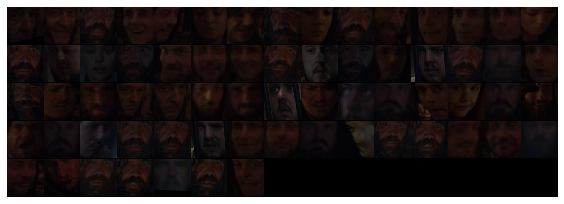

In [40]:
#@title Filter by face darkness. Threshold is of V (value) in HSV color-space.
threshold = 25 #@param {type:"number"}

def tooDark(face, threshold):
  hsvImage = mpl.colors.rgb_to_hsv(face.image)
  meanValue = np.mean(hsvImage[:,:,2])
  return meanValue < threshold

darkFaces = []
for face in allFaces:
  if tooDark(face, threshold):
    darkFaces.append(face)
    
print('%d of %d faces get filtered out for being too dark.' % (len(darkFaces), len(allFaces)))

showFaces(darkFaces)

65 of 795 faces get filtered out for being too small.


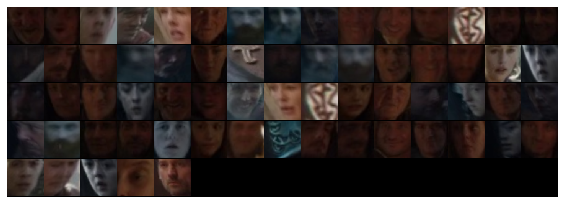

In [65]:
#@title Filter by face size. Threshold is width/height in pixels.
threshold = 37 #@param {type:"number"}

def tooSmall(face, threshold):
  br = face.bbBottomRight
  tl = face.bbTopLeft
  
  height = br[1] - tl[1]
  width = br[0] - tl[0]
  return height < threshold or width < threshold

smallFaces = []
for face in allFaces:
  if tooSmall(face, threshold):
    smallFaces.append(face)
    
print('%d of %d faces get filtered out for being too small.' % (len(smallFaces), len(allFaces)))

showFaces(smallFaces)

Size seems to be a bad filtering metric, so I will ommit from later filtering steps.

65 of 795 faces get filtered out for being too small.


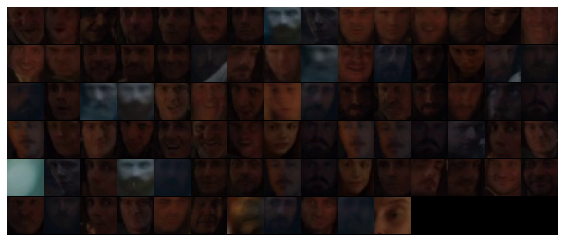

In [55]:
#@title Filter by face blurriness. Threshold is standard deviation of Laplacian.
threshold = 0.006 #@param {type:"number"}

def tooBlurry(face, threshold):
  im = face.image
  im = skimage.color.rgb2gray(im)
  L = scipy.ndimage.filters.laplace(im)
  std = np.std(L)
  
  return std < threshold

blurryFaces = []
for face in allFaces:
  if tooBlurry(face, threshold):
    blurryFaces.append(face)
    
print('%d of %d faces get filtered out for being too small.' % (len(smallFaces), len(allFaces)))

showFaces(blurryFaces)

In [0]:
#@title For a random selection of faces, shows which characters were discussed in the specified interval after the face appeared.
minutes = 1 #@param {type:"slider", min:0, max:10, step:1}
numFacesToShow = 0 #@param {type:"slider", min:0, max:10, step:1}

filteredFaces = set(faces) - set(blurryFaces) - set(darkFaces)

for idx in range(numFacesToShow):
  face = random.choice(filteredFaces)